# Timeseries

[statsmodels.tsa](https://www.statsmodels.org/stable/tsa.html#module-statsmodels.tsa)

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Données

In [3]:
from ensae_teaching_cs.data import generate_sells
import pandas
df = pandas.DataFrame(generate_sells())
df.head()

,date,value
0,2017-07-08 23:03:52.465524,0.010406
1,2017-07-09 23:03:52.465524,0.000000
2,2017-07-10 23:03:52.465524,0.003553
3,2017-07-11 23:03:52.465524,0.004651
4,2017-07-12 23:03:52.465524,0.004587


## Premiers graphiques

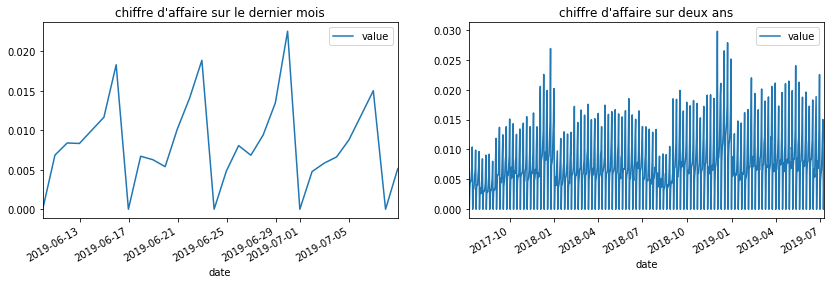

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df.iloc[-30:].set_index('date').plot(ax=ax[0])
df.set_index('date').plot(ax=ax[1])
ax[0].set_title("chiffre d'affaire sur le dernier mois")
ax[1].set_title("chiffre d'affaire sur deux ans");

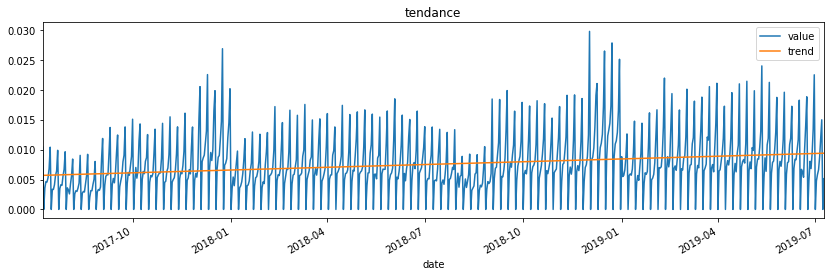

In [5]:
from statsmodels.tsa.tsatools import detrend
notrend = detrend(df.value)
df["notrend"] = notrend
df["trend"] = df['value'] - notrend
ax = df.plot(x="date", y=["value", "trend"], figsize=(14,4))
ax.set_title('tendance');

In [6]:
from statsmodels.tsa.stattools import acf
cor = acf(df.value)
cor

array([ 1.00000000e+00,  2.15681662e-02, -5.15029420e-02, -3.18454836e-02,
       -3.42441007e-02, -5.60896295e-02,  1.01188999e-02,  9.37984023e-01,
        5.26861581e-04, -7.11719760e-02, -5.23301106e-02, -5.47946422e-02,
       -7.68167489e-02, -1.37390460e-02,  8.99377407e-01, -2.41889983e-02,
       -9.21415847e-02, -7.09927082e-02, -7.43376684e-02, -9.50244429e-02,
       -3.76107281e-02,  8.63006385e-01, -4.62789569e-02, -1.10106622e-01,
       -8.73793640e-02, -9.41615504e-02, -1.16306243e-01, -5.59254481e-02,
        8.28033155e-01, -6.73898940e-02, -1.29452695e-01, -1.09771088e-01,
       -1.11659153e-01, -1.30404154e-01, -6.94934983e-02,  8.03519787e-01,
       -7.54754373e-02, -1.32915490e-01, -1.10653233e-01, -1.13530928e-01,
       -1.29432806e-01])

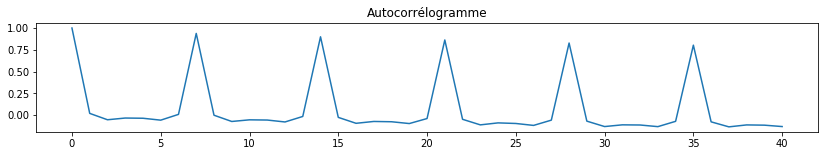

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(14,2))
ax.plot(cor)
ax.set_title("Autocorrélogramme");

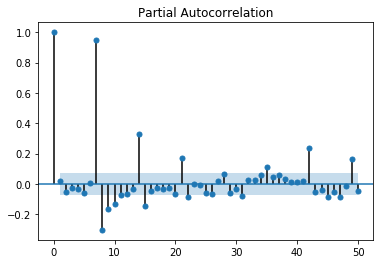

In [8]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.value, lags=50);

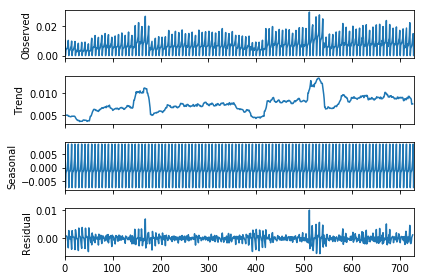

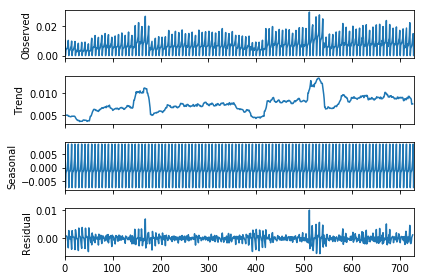

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df.value, freq=7)
res.plot()

## Prediction

In [10]:
from statsmodels.tsa.tsatools import lagmat
lag = 8
X = lagmat(df["value"], lag)
lagged = df.copy()
for c in range(1,lag+1):
    lagged["lag%d" % c] = X[:, c-1]
data = pandas.concat([lagged.head(), lagged.tail()])
data.tail()

,date,value,notrend,trend,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
726,2019-07-04 23:03:52.465524,0.008750,-0.000635,0.009384,0.006617,0.005841,0.004768,0.000000,0.022525,0.013453,0.009376,0.006834
727,2019-07-05 23:03:52.465524,0.011860,0.002471,0.009389,0.008750,0.006617,0.005841,0.004768,0.000000,0.022525,0.013453,0.009376
728,2019-07-06 23:03:52.465524,0.014996,0.005601,0.009394,0.011860,0.008750,0.006617,0.005841,0.004768,0.000000,0.022525,0.013453
729,2019-07-07 23:03:52.465524,0.000000,-0.009399,0.009399,0.014996,0.011860,0.008750,0.006617,0.005841,0.004768,0.000000,0.022525
730,2019-07-08 23:03:52.465524,0.005142,-0.004263,0.009404,0.000000,0.014996,0.011860,0.008750,0.006617,0.005841,0.004768,0.000000


In [11]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(lagged):
    data_train, data_test = lagged.iloc[train_index, :], lagged.iloc[test_index, :]
    print("TRAIN:", data_train.shape, "TEST:", data_test.shape)
    

TRAIN: (126, 12) TEST: (121, 12)
TRAIN: (247, 12) TEST: (121, 12)
TRAIN: (368, 12) TEST: (121, 12)
TRAIN: (489, 12) TEST: (121, 12)
TRAIN: (610, 12) TEST: (121, 12)


In [12]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(data_train.drop(["value", "date", "notrend", "trend"], axis=1), data_train.value)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
from sklearn.metrics import r2_score
r2 = r2_score(data_test.value,
              clr.predict(data_test.drop(["value", "date", "notrend", "trend"], axis=1).as_matrix()))
r2

c:\python372_x64\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0.9278737366663775

In [14]:
for i in range(1, 9):
    print(i, ":", r2_score(data_test.value, data_test["lag%d" % i]))

1 : -1.2924536644826863
2 : -1.3659940324607538
3 : -1.3645855092154435
4 : -1.3334744310306683
5 : -1.3103625825093088
6 : -1.2323400735358132
7 : 0.9293926311105688
8 : -1.3357803204982397
